**Import Dependencies and Data**

building a GANN to generate fashion:
getting images from tfds and using fashion_mnist dataset

In [4]:
#installing all the dependencies
%pip install tensorflow matplotlib tensorflow-datasets ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: C:\Users\Amir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [3]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Amir\tensorflow_datasets\fashion_mnist\incomplete.5VH4TV_3.0.1\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Amir\tensorflow_datasets\fashion_mnist\incomplete.5VH4TV_3.0.1\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\Amir\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [12]:
#exploring the ds
print(ds)
print (type(ds))
ds.as_numpy_iterator().next().keys()

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


dict_keys(['image', 'label'])

**Viz Data and Build Dataset**

In [13]:
# Do some data transformation
import numpy as np

# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

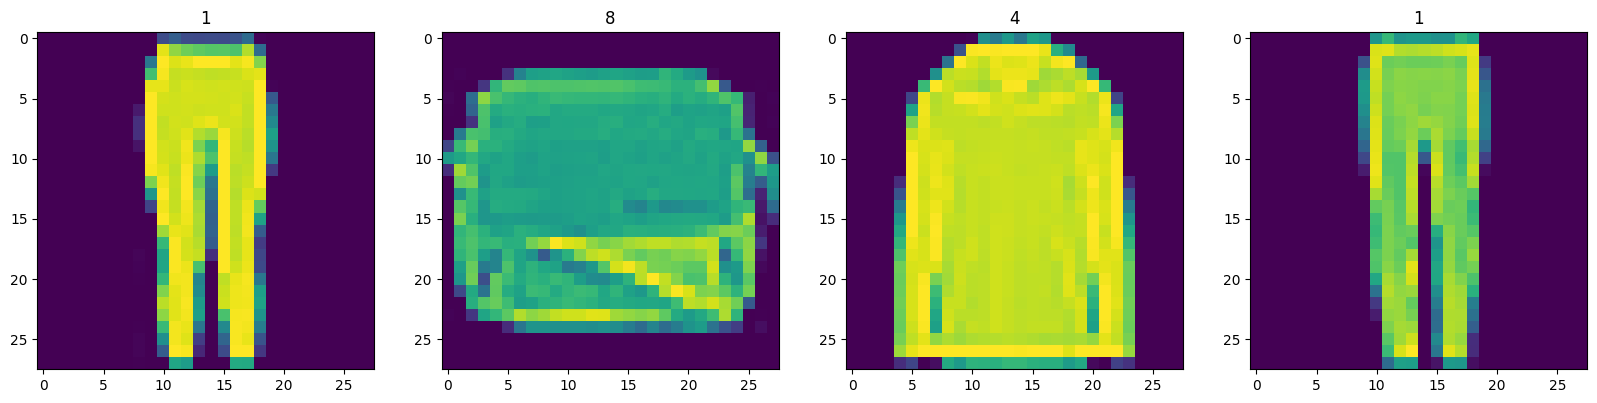

In [14]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])